In [1]:
import sys
import os
import requests
import torch
import numpy as np
from tqdm import tqdm

import matplotlib.pyplot as plt
from PIL import Image
import torch.nn.functional as F
from torch import nn

sys.path.append('..')
from text_conditioned_mae import TextConditionedMaskedAutoencoderViT, copy_weights_mae_textmae, get_mae_vit_large_patch16_text_conditioned
import models_mae
import pickle

c:\Users\aravi\miniconda3\envs\mml-mae\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
# define the utils

imagenet_mean = np.array([0.485, 0.456, 0.406])
imagenet_std = np.array([0.229, 0.224, 0.225])

def show_image(image, title=''):
    # image is [H, W, 3]
    assert image.shape[2] == 3
    plt.imshow(torch.clip((image * imagenet_std + imagenet_mean) * 255, 0, 255).int())
    plt.title(title, fontsize=16)
    plt.axis('off')
    return

def prepare_model(chkpt_dir, arch='mae_vit_large_patch16'):
    # build model
    model = getattr(models_mae, arch)()
    # load model
    checkpoint = torch.load(chkpt_dir, map_location='cpu')
    msg = model.load_state_dict(checkpoint['model'], strict=False)
    print(msg)
    return model

def run_one_image_mse(img, model):
    x = torch.tensor(img)

    # make it a batch-like
    x = x.unsqueeze(dim=0)
    x = torch.einsum('nhwc->nchw', x)

    # run MAE
    loss, y, mask = model(x.float(), mask_ratio=0.75)
    y = model.unpatchify(y)
    y = torch.einsum('nchw->nhwc', y).detach().cpu()

    # visualize the mask
    mask = mask.detach()
    mask = mask.unsqueeze(-1).repeat(1, 1, model.patch_embed.patch_size[0]**2 *3)  # (N, H*W, p*p*3)
    mask = model.unpatchify(mask)  # 1 is removing, 0 is keeping
    mask = torch.einsum('nchw->nhwc', mask).detach().cpu()
    
    x = torch.einsum('nchw->nhwc', x)

    # masked image
    im_masked = x * (1 - mask)

    # MAE reconstruction pasted with visible patches
    im_paste = x * (1 - mask) + y * mask
    reconstructed_image = (y * mask)[0]
    original_image_non_masked = (x * mask)[0]
    mse_loss = torch.nn.functional.mse_loss(reconstructed_image, original_image_non_masked).item()
    return mse_loss

def run_one_image(img, model):
    x = torch.tensor(img)

    # make it a batch-like
    x = x.unsqueeze(dim=0)
    x = torch.einsum('nhwc->nchw', x)

    # run MAE
    loss, y, mask = model(x.float(), mask_ratio=0.75)
    y = model.unpatchify(y)
    y = torch.einsum('nchw->nhwc', y).detach().cpu()

    # visualize the mask
    mask = mask.detach()
    mask = mask.unsqueeze(-1).repeat(1, 1, model.patch_embed.patch_size[0]**2 *3)  # (N, H*W, p*p*3)
    mask = model.unpatchify(mask)  # 1 is removing, 0 is keeping
    mask = torch.einsum('nchw->nhwc', mask).detach().cpu()
    
    x = torch.einsum('nchw->nhwc', x)

    # masked image
    im_masked = x * (1 - mask)

    # MAE reconstruction pasted with visible patches
    im_paste = x * (1 - mask) + y * mask

    # make the plt figure larger
    plt.rcParams['figure.figsize'] = [24, 24]

    plt.subplot(1, 4, 1)
    show_image(x[0], "original")

    plt.subplot(1, 4, 2)
    show_image(im_masked[0], "masked")

    plt.subplot(1, 4, 3)
    show_image(y[0], "reconstruction")

    plt.subplot(1, 4, 4)
    show_image(im_paste[0], "reconstruction + visible")

    plt.show()


def run_one_image_get_embeddings(img, model, verbose=False):
    x = torch.tensor(img)

    # make it a batch-like
    x = x.unsqueeze(dim=0)
    x = torch.einsum('nhwc->nchw', x)
    imgs = x.float()
    # run MAE
    latents, mask, ids_restore = model.forward_encoder(imgs, mask_ratio=0.75)
    if verbose:
        y = model.forward_decoder(latents, ids_restore)  # [N, L, p*p*3]
        loss = model.forward_loss(imgs, y, mask)
        y = model.unpatchify(y)
        y = torch.einsum('nchw->nhwc', y).detach().cpu()

        # visualize the mask
        mask = mask.detach()
        mask = mask.unsqueeze(-1).repeat(1, 1, model.patch_embed.patch_size[0]**2 *3)  # (N, H*W, p*p*3)
        mask = model.unpatchify(mask)  # 1 is removing, 0 is keeping
        mask = torch.einsum('nchw->nhwc', mask).detach().cpu()
        
        x = torch.einsum('nchw->nhwc', x)

        # masked image
        im_masked = x * (1 - mask)

        # MAE reconstruction pasted with visible patches
        im_paste = x * (1 - mask) + y * mask

        # make the plt figure larger
        plt.rcParams['figure.figsize'] = [24, 24]

        plt.subplot(1, 4, 1)
        show_image(x[0], "original")

        plt.subplot(1, 4, 2)
        show_image(im_masked[0], "masked")

        plt.subplot(1, 4, 3)
        show_image(y[0], "reconstruction")

        plt.subplot(1, 4, 4)
        show_image(im_paste[0], "reconstruction + visible")

        plt.show()
    return latents.detach().cpu().numpy()[0]

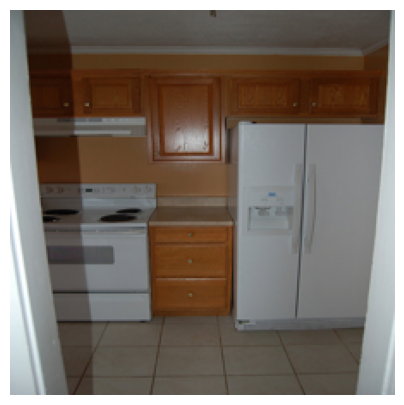

In [4]:
val_dir = "C:\\Users\\aravi\\OneDrive\\Aravind Important\\Carnegie Mellon\\Semesters\\Fall24\\MML\\Project\\Dataset\\val2017"
image_path = os.path.join(val_dir, "000000000802.jpg")
img = Image.open(image_path)
img = img.resize((224, 224))
img = np.array(img) / 255.

assert img.shape == (224, 224, 3)

# normalize by ImageNet mean and std
img = img - imagenet_mean
img = img / imagenet_std

plt.rcParams['figure.figsize'] = [5, 5]
show_image(torch.tensor(img))

In [5]:
chkpt_dir = 'mae_visualize_vit_large.pth'
model_mae = prepare_model(chkpt_dir, 'mae_vit_large_patch16')
print('Model loaded.')

<All keys matched successfully>
Model loaded.


In [6]:
text_conditioned_vitL_P16 = get_mae_vit_large_patch16_text_conditioned()
text_conditioned_vitL_P16 = copy_weights_mae_textmae(model_mae, text_conditioned_vitL_P16)

In [7]:
# A function to calculate all trainable parameters of a pytorch model
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
num_trainable_parameters = count_parameters(text_conditioned_vitL_P16)
print(f'The model has {num_trainable_parameters:,} trainable parameters')

The model has 430,051,073 trainable parameters


In [8]:
type(text_conditioned_vitL_P16), type(model_mae)

(text_conditioned_mae.TextConditionedMaskedAutoencoderViT,
 models_mae.MaskedAutoencoderViT)

In [9]:
def run_one_image_verify_copy(img, text_conditioned_model):
    x = torch.tensor(img)

    # make it a batch-like
    x = x.unsqueeze(dim=0)
    x = torch.einsum('nhwc->nchw', x)

    # run MAE
    print("Input shape: ", x.shape)
    loss, y, mask, itm_probs = text_conditioned_model(x.float(), None, None, mask_ratio=0.75, skip_cross_attn=True)
    y = text_conditioned_model.unpatchify(y)
    y = torch.einsum('nchw->nhwc', y).detach().cpu()

    # visualize the mask
    mask = mask.detach()
    mask = mask.unsqueeze(-1).repeat(1, 1, text_conditioned_model.patch_embed.patch_size[0]**2 *3)  # (N, H*W, p*p*3)
    mask = text_conditioned_model.unpatchify(mask)  # 1 is removing, 0 is keeping
    mask = torch.einsum('nchw->nhwc', mask).detach().cpu()
    
    x = torch.einsum('nchw->nhwc', x)

    # masked image
    im_masked = x * (1 - mask)

    # MAE reconstruction pasted with visible patches
    im_paste = x * (1 - mask) + y * mask

    # make the plt figure larger
    plt.rcParams['figure.figsize'] = [24, 24]

    plt.subplot(1, 4, 1)
    show_image(x[0], "original")

    plt.subplot(1, 4, 2)
    show_image(im_masked[0], "masked")

    plt.subplot(1, 4, 3)
    show_image(y[0], "reconstruction")

    plt.subplot(1, 4, 4)
    show_image(im_paste[0], "reconstruction + visible")

    plt.show()

MAE with pixel reconstruction:
Input shape:  torch.Size([1, 3, 224, 224])


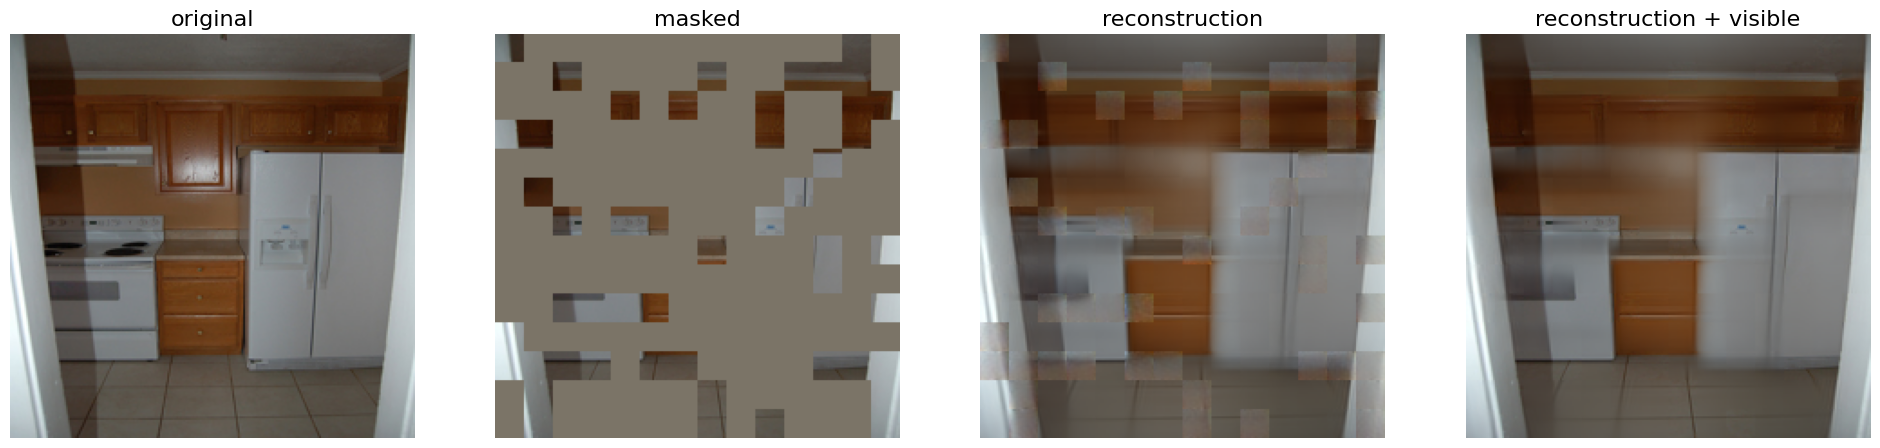

In [10]:
# make random mask reproducible (comment out to make it change)
# torch.manual_seed(2)
print('MAE with pixel reconstruction:')
run_one_image_verify_copy(img, text_conditioned_vitL_P16)

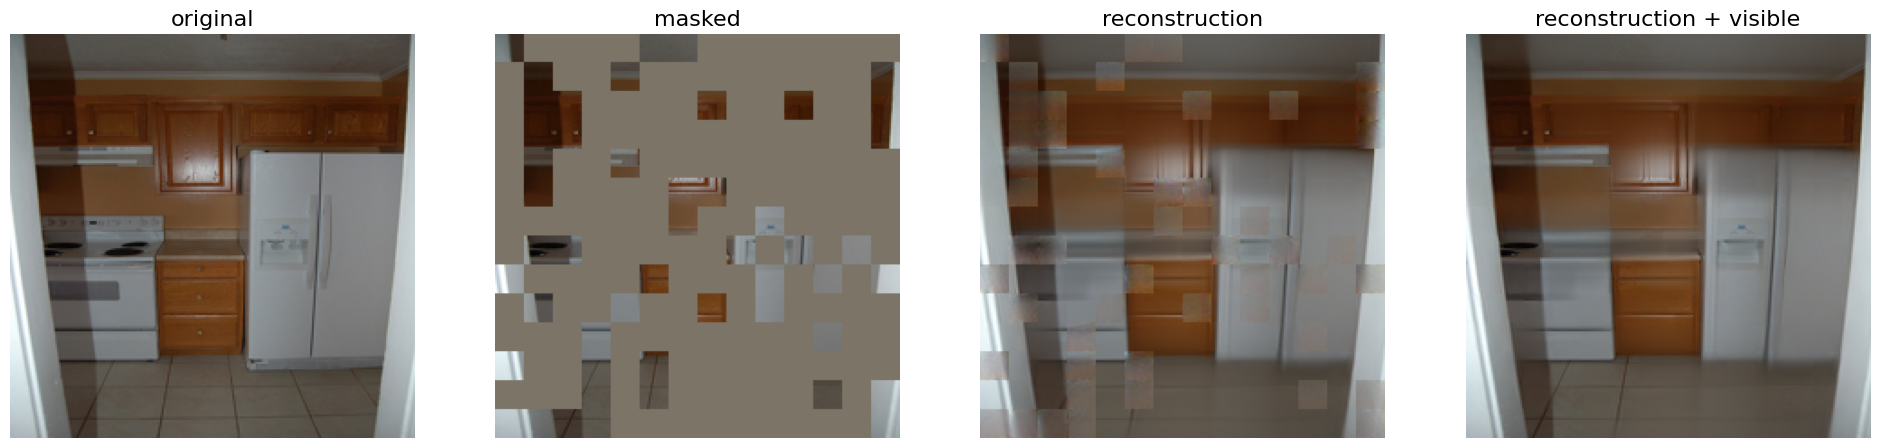

In [11]:
run_one_image(img, model_mae)

# Test Dataloader

In [12]:
import sys
sys.path.append("..")
from text_conditioned_dataloader import get_dataloaders
train_loader, val_loader = get_dataloaders(64, 0.5)

In [13]:
images_tensor, padded_text_embeddings, text_attention_mask, labels_tensor = next(iter(val_loader))
images_tensor.shape, padded_text_embeddings.shape, text_attention_mask.shape, labels_tensor.shape

(torch.Size([64, 3, 224, 224]),
 torch.Size([64, 29, 1024]),
 torch.Size([64, 29]),
 torch.Size([64]))

In [14]:
temp_path = "Checkpoints\\checkpoint-10.pth"
checkpoint = torch.load(temp_path, map_location='cpu')
text_conditioned_vitL_P16.load_state_dict(checkpoint['model'])
text_conditioned_vitL_P16 = text_conditioned_vitL_P16.eval()

In [15]:
print((text_attention_mask[0, :]))
print((text_attention_mask[1, :]))
text_conditioned_vitL_P16 = text_conditioned_vitL_P16.to(device)

tensor([ True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True, False,
        False, False, False, False, False, False, False, False, False],
       device='cuda:0')
tensor([ True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True, False, False, False, False,
        False, False, False, False, False, False, False, False, False],
       device='cuda:0')


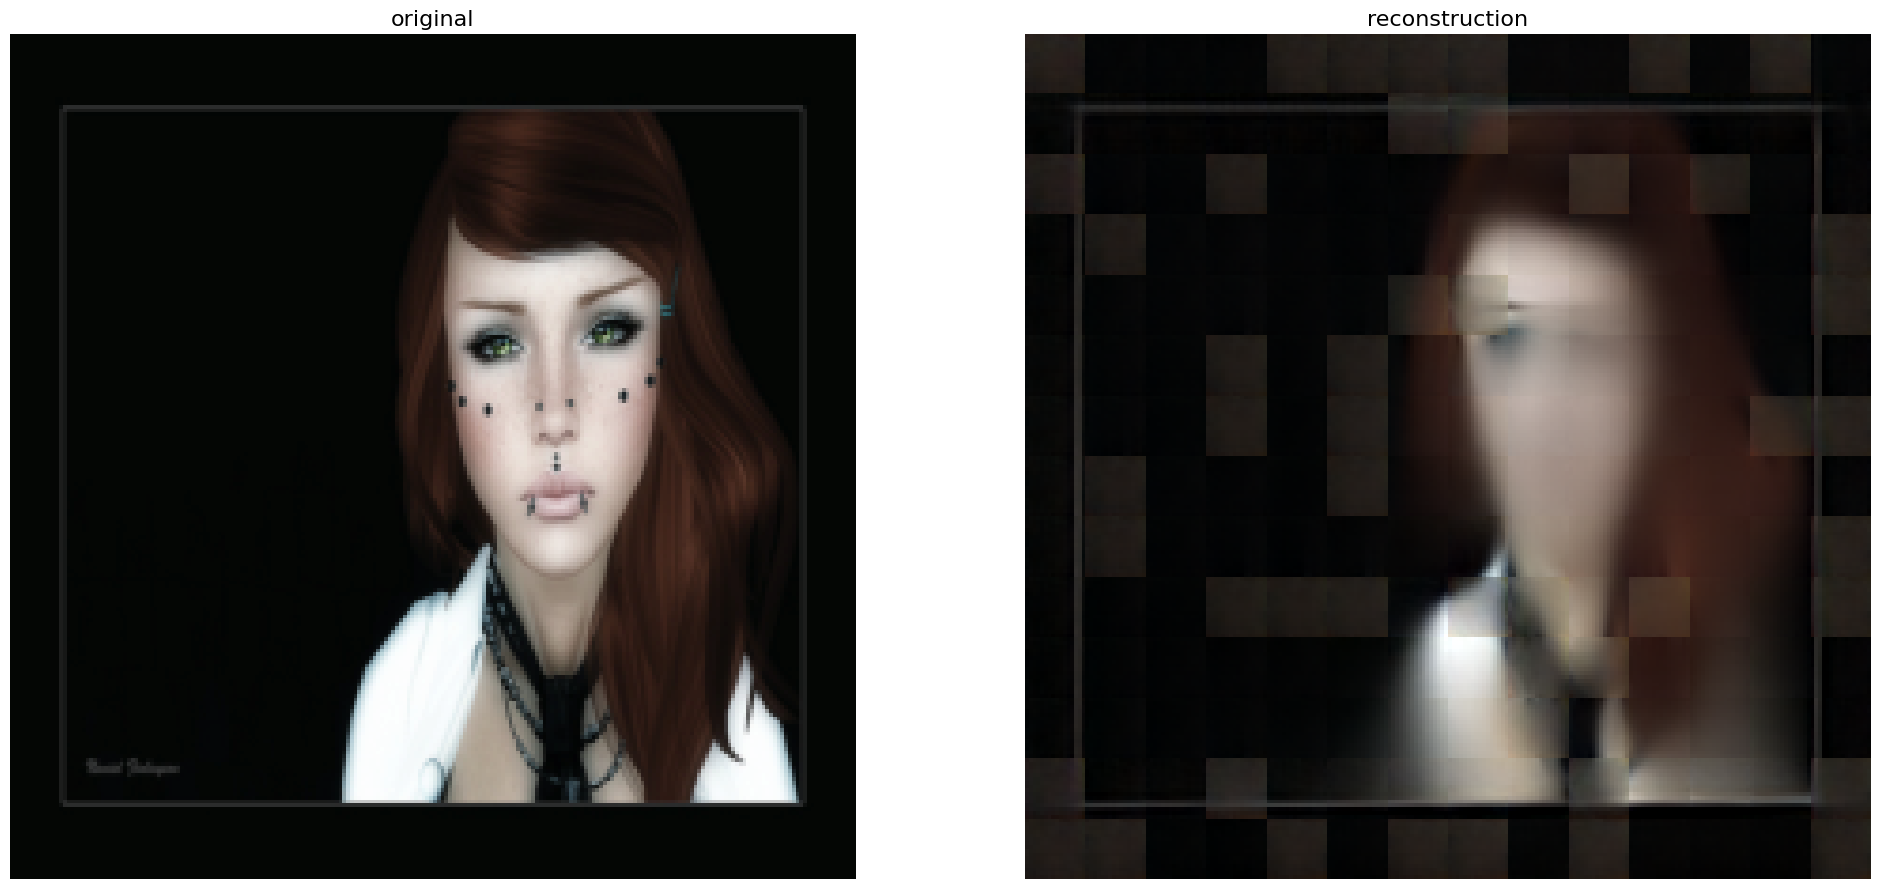

In [16]:
with torch.no_grad():
    loss, y, mask, itm_probs = text_conditioned_vitL_P16(images_tensor, padded_text_embeddings, text_attention_mask, mask_ratio=0.75, skip_cross_attn=False)
    y = text_conditioned_vitL_P16.unpatchify(y)
    y = torch.einsum('nchw->nhwc', y).detach().cpu()
    temp_image_tensor = torch.einsum('nchw->nhwc', images_tensor).detach().cpu()
    plt.rcParams['figure.figsize'] = [24, 24]
    plt.subplot(1, 2, 1)
    show_image(temp_image_tensor[43], "original")
    plt.subplot(1, 2, 2)
    show_image(y[43], "reconstruction")

In [17]:
from text_conditioned_dataloader import ImageTextDataset, collate_fn
from typing import List, Tuple, Set
import json

train_file_path = "C:\\Users\\aravi\\OneDrive\\Aravind Important\\Carnegie Mellon\\Semesters\\Fall24\\MML\\Project\\Dataset\\annotations\\captions_train2017.json"
val_file_path = "C:\\Users\\aravi\\OneDrive\\Aravind Important\\Carnegie Mellon\\Semesters\\Fall24\\MML\\Project\\Dataset\\annotations\\captions_val2017.json"
train_image_folder = "C:\\Users\\aravi\\OneDrive\\Aravind Important\\Carnegie Mellon\\Semesters\\Fall24\\MML\\Project\\Dataset\\train2017"
val_image_folder = "C:\\Users\\aravi\\OneDrive\\Aravind Important\\Carnegie Mellon\\Semesters\\Fall24\\MML\\Project\\Dataset\\val2017"
negative_prob = 0.5

def extract_images_and_captions(image_folder: str, data: dict) -> Tuple[List[Tuple[str, List[str]]], Set[str]]:
    images_dict = {img['id']: img['file_name'] for img in data['images']}
    captions_dict = {}
    all_captions_set = set()
    
    for ann in data['annotations']:
        img_id = ann['image_id']
        caption = ann['caption'].strip()
        all_captions_set.add(caption)
        captions_dict.setdefault(img_id, []).append(caption)
    
    pairs_list = [(os.path.join(image_folder, images_dict[img_id]), captions_dict[img_id]) 
                    for img_id in images_dict if img_id in captions_dict]
    
    return pairs_list, all_captions_set

with open(train_file_path, 'r') as file:
    train_data = json.load(file)

with open(val_file_path, 'r') as file:
    val_data = json.load(file)

train_image_caption_pairs, train_all_captions = extract_images_and_captions(train_image_folder, train_data)
val_image_caption_pairs, val_all_captions = extract_images_and_captions(val_image_folder, val_data)

train_dataset = ImageTextDataset(train_image_caption_pairs, train_all_captions, positive_pair_prob=negative_prob)
val_dataset = ImageTextDataset(val_image_caption_pairs, val_all_captions, positive_pair_prob=negative_prob)

In [18]:
import pickle
def save_python_obj(obj, path):
    with open(path, 'wb') as f:
        pickle.dump(obj, f)
def load_python_obj(path):
    with open(path, 'rb') as f:
        return pickle.load(f)

In [ ]:
cache_image_name = {}
mask_ratio = 0.75
# cache_path = f'cache_image_name_{mask_ratio}.pkl'
cache_path = f'cache_image_name_hidden.pkl'
if os.path.exists(cache_path):
    cache_image_name = load_python_obj(cache_path)
bs = 64
results = []
num_correct = 0
num_total = 0
from tqdm import tqdm
import torch
import random
list_for_vlc = []
losses = []
with torch.no_grad():
    pbar = tqdm(total=len(val_dataset), position=0, leave=True)
    pbar.set_description(f'Val Acc: {num_correct/num_total if num_total > 0 else 0:.2f}')
    for i in range(0, len(val_dataset), bs):
        batch = []
        for k in range(i, min(i+bs, len(val_dataset))):
            random.seed(k)
            # random.seed(1)
            curr_item = val_dataset[k]
            list_for_vlc.append((os.path.basename(val_dataset.image_caption_pairs[k][0]), curr_item[1], curr_item[2].item()))
            curr_path = os.path.basename(val_dataset.image_caption_pairs[k][0])
            batch.append(curr_item)
        images_tensor, embeddings, text_attention_mask, labels_tensor = collate_fn(batch)
        # loss, y, mask, itm_probs = text_conditioned_vitL_P16(images_tensor, embeddings, text_attention_mask, mask_ratio=0.0, skip_cross_attn=False)
        loss, y, mask, itm_probs = text_conditioned_vitL_P16(images_tensor, embeddings, text_attention_mask, mask_ratio=mask_ratio, skip_cross_attn=False)
        
        for j in range(images_tensor.shape[0]):
            img = images_tensor[j].detach().cpu()
            itm_prob = itm_probs[j].detach().cpu().item()
            label_idm = labels_tensor[j].detach().cpu().item()
            match = (itm_prob > 0.5) == label_idm
            results.append((img, batch[j][1], itm_prob, label_idm, match))
            num_correct += match
            num_total += 1
            # cache_image_name[curr_path] = loss.detach().cpu().item()
            cache_image_name[curr_path] = loss.detach().cpu().item()
        # Update progress bar with new accuracy
        accuracy = num_correct / num_total if num_total > 0 else 0
        pbar.set_description(f'Val Acc: {accuracy:.2f}')
        pbar.update(bs)
save_python_obj(cache_image_name, cache_path)

Val Acc: 0.92: : 5056it [03:15, 25.81it/s]
Val Acc: 0.83: : 5056it [01:04, 107.69it/s]                       

In [44]:
accuracy = num_correct / num_total if num_total > 0 else 0
print(f'Validation accuracy: {accuracy}')

Validation accuracy: 0.8342


Val Acc: 0.83: : 5056it [01:17, 107.69it/s]

In [37]:
label_1 = 0
label_0 = 0
for i in range(len(results)):
    if results[i][3] == 1:
        label_1 += 1
    else:
        label_0 += 1
print("Label 1: ", label_1)
print("Label 0: ", label_0)
print("Total: ", len(results))

Label 1:  2523
Label 0:  2477
Total:  5000


In [41]:
# # Save list_for_vlc
# import pickle
# with open("list_for_vlc.pkl", "wb") as f:
#     pickle.dump(list_for_vlc, f)

# with open("list_for_vlc.pkl", "rb") as f:
#     list_for_vlc = pickle.load(f)
# print("Accuracy: ", num_correct / num_total)

In [42]:
def load_pkl(file_path):
    with open(file_path, "rb") as f:
        return pickle.load(f)

In [50]:
import torchvision.transforms as transforms
def load_image(image_path):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    image = Image.open(image_path).convert('RGB')
    image_tensor = transform(image)
    return image_tensor

In [51]:
def process_data(data, bs=64, label=None):
    with torch.no_grad():
        len_data = len(data)
        assert bs % 2 == 0
        all_data = []
        for i in tqdm(sorted([int(i) for i in data.keys()])):
            k = str(i)
            image_path = os.path.join(val_image_folder, data[k]['filename'])
            all_data.append((load_image(image_path), data[k]['caption'], torch.tensor(1)))
            all_data.append((load_image(image_path), data[k]['negative_caption'], torch.tensor(0)))

        num_correct = 0
        num_total = 0
        pbar = tqdm(total=len(all_data), position=0, leave=True)
        pbar.set_description(f'Val Acc: {num_correct/num_total if num_total > 0 else 0:.2f}')
        for i in range(0, len(all_data), bs):
            batch = []
            for k in range(i, min(i+bs, len(all_data))):
                batch.append(all_data[k])
            images_tensor, embeddings, text_attention_mask, labels_tensor = collate_fn(batch)
            # print(images_tensor.shape, embeddings.shape, text_attention_mask.shape, labels_tensor.shape)
            loss, y, mask, itm_probs = text_conditioned_vitL_P16(images_tensor, embeddings, text_attention_mask, mask_ratio=0, skip_cross_attn=False)
            
            for j in range(0, images_tensor.shape[0], 2):
                img = images_tensor[j].detach().cpu()
                itm_prob_positive = itm_probs[j].detach().cpu().item()
                itm_prob_negative = itm_probs[j+1].detach().cpu().item()
                match = itm_prob_positive > itm_prob_negative
                num_correct += match
                num_total += 1
            accuracy = num_correct / num_total if num_total > 0 else 0
            pbar.set_description(f'Val Acc: {accuracy:.2f}')
            pbar.update(bs)
    print(f"Sugarcrepe label: {label}, Accuracy: {num_correct/num_total if num_total > 0 else 0:.2f}, number of data points: {num_total}")
    # print(f'Accuracy: {num_correct/num_total if num_total > 0 else 0:.2f}, number of data points: {num_total}')
    return num_correct/num_total

In [25]:
data_dir = "C:\\Users\\aravi\\OneDrive\\Aravind Important\\Carnegie Mellon\\Semesters\\Fall24\\MML\\Project\\sugar-crepe\\data"
final_metrics = {}
for json_file in os.listdir(data_dir):
    json_file_path = os.path.join(data_dir, json_file)
    with open(json_file_path, 'r') as file:
        data = json.load(file)
    final_metrics[json_file] = process_data(data, bs=64, label=json_file)

100%|██████████| 692/692 [00:23<00:00, 29.92it/s]
Val Acc: 0.50: : 1408it [00:36, 43.60it/s]                        

Sugarcrepe label: add_att.json, Accuracy: 0.50, number of data points: 692


Val Acc: 0.50: : 1408it [00:36, 38.56it/s]
100%|██████████| 2062/2062 [01:18<00:00, 26.14it/s]
Val Acc: 0.55: : 4160it [01:51, 41.07it/s]                        

Sugarcrepe label: add_obj.json, Accuracy: 0.55, number of data points: 2062


Val Acc: 0.55: : 4160it [01:52, 36.96it/s]
100%|██████████| 788/788 [00:25<00:00, 30.39it/s]
Val Acc: 0.57: : 1600it [00:44, 38.82it/s]                        

Sugarcrepe label: replace_att.json, Accuracy: 0.57, number of data points: 788


Val Acc: 0.57: : 1600it [00:44, 35.93it/s]
100%|██████████| 1652/1652 [00:42<00:00, 38.44it/s]
Val Acc: 0.60: : 3328it [01:32, 36.81it/s]                        

Sugarcrepe label: replace_obj.json, Accuracy: 0.60, number of data points: 1652


Val Acc: 0.60: : 3328it [01:32, 36.01it/s]
100%|██████████| 1406/1406 [00:17<00:00, 78.74it/s]
Val Acc: 0.61: : 2816it [01:25, 33.07it/s]                        

Sugarcrepe label: replace_rel.json, Accuracy: 0.61, number of data points: 1406



100%|██████████| 666/666 [00:09<00:00, 67.78it/s]
Val Acc: 0.52: : 1344it [00:41, 32.16it/s]                        


Sugarcrepe label: swap_att.json, Accuracy: 0.52, number of data points: 666


100%|██████████| 245/245 [00:04<00:00, 56.73it/s]
Val Acc: 0.58: : 512it [00:15, 32.44it/s]                       

Sugarcrepe label: swap_obj.json, Accuracy: 0.58, number of data points: 245


In [26]:
final_metrics

{'add_att.json': 0.5014450867052023,
 'add_obj.json': 0.5543161978661494,
 'replace_att.json': 0.5710659898477157,
 'replace_obj.json': 0.6035108958837773,
 'replace_rel.json': 0.6109530583214794,
 'swap_att.json': 0.5180180180180181,
 'swap_obj.json': 0.5795918367346938}

In [45]:
overall_accuracy = 0
list_for_vlc = load_pkl("list_for_vlc_og.pkl")

In [ ]:
bs = 64
results = []
num_correct = 0
num_total = 0
from tqdm import tqdm
import torch
import random
with torch.no_grad():
    pbar = tqdm(total=len(list_for_vlc), position=0, leave=True)
    pbar.set_description(f'Val Acc: {num_correct/num_total if num_total > 0 else 0:.2f}')
    for i in range(0, len(list_for_vlc), bs):
        batch = []
        for k in range(i, min(i+bs, len(list_for_vlc))):
            random.seed(k)
            curr_item = list_for_vlc[k]
            image_full_path = os.path.join(val_image_folder, curr_item[0])
            new_curr_item = (load_image(image_full_path), curr_item[1], torch.tensor(curr_item[2]))
            batch.append(new_curr_item)
        images_tensor, embeddings, text_attention_mask, labels_tensor = collate_fn(batch)
        loss, y, mask, itm_probs = text_conditioned_vitL_P16(images_tensor, embeddings, text_attention_mask, mask_ratio=0, skip_cross_attn=False)

        for j in range(images_tensor.shape[0]):
            img = images_tensor[j].detach().cpu()
            itm_prob = itm_probs[j].detach().cpu().item()
            label_idm = labels_tensor[j].detach().cpu().item()
            match = (itm_prob > 0.5) == label_idm
            results.append((img, batch[j][1], itm_prob, label_idm, match))
            num_correct += match
            num_total += 1
        
        # Update progress bar with new accuracy
        accuracy = num_correct / num_total if num_total > 0 else 0
        pbar.set_description(f'Val Acc: {accuracy:.2f}')
        pbar.update(bs)

Val Acc: 0.94: : 5056it [03:49, 22.03it/s]
Val Acc: 0.95: : 5056it [02:35, 40.06it/s]                        

In [47]:
print("Accuracy: ", num_correct / num_total)

Accuracy:  0.9522


Val Acc: 0.95: : 5056it [02:48, 40.06it/s]

# Reconstruction Error

In [24]:
import json
coco_metadata_apth = r"C:\Users\aravi\OneDrive\Aravind Important\Carnegie Mellon\Semesters\Fall24\MML\Project\Dataset\annotations\instances_val2017.json"
with open(coco_metadata_apth, 'r') as f:
    coco_metadata = json.load(f)
coco_metadata["annotations"][0]["image_id"]

289343

In [25]:
image_object_count = {}
for annotation in coco_metadata["annotations"]:
    image_id = annotation["image_id"]
    if image_id in image_object_count:
        image_object_count[image_id] += 1
    else:
        image_object_count[image_id] = 1

count_to_images = {}
for image_id, count in image_object_count.items():
    if count in count_to_images:
        count_to_images[count].append(image_id)
    else:
        count_to_images[count] = [image_id]
sorted(count_to_images.keys())
count_to_average_reconstuction_error = {}
for count, image_ids in count_to_images.items():
    total_mse = 0
    for image_id in image_ids:
        image_id_str = str(image_id).zfill(12)
        image_path =  f"{image_id_str}.jpg"
        curr_mse = cache_image_name[image_path]
        total_mse += curr_mse
    count_to_average_reconstuction_error[count] = total_mse / len(image_ids)
# sorted(count_to_average_reconstuction_error.items(), key=lambda x: x[0])

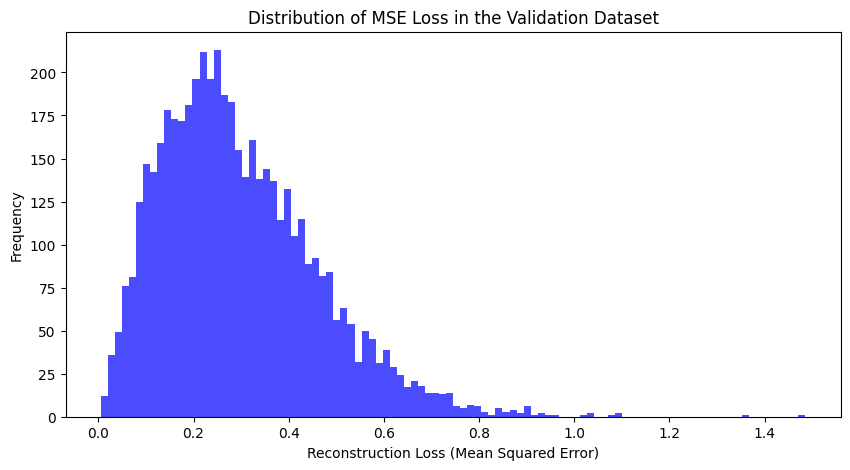

In [26]:
# Plot a graph which shows the distribution of different reconstruction loss in the dataset
import matplotlib.pyplot as plt

different_mse_values = [v for k, v in cache_image_name.items()]
# Plot the histogram with clean annotations

plt.rcParams['figure.figsize'] = [10, 5]
plt.title("Distribution of MSE Loss in the Validation Dataset")
plt.xlabel("Reconstruction Loss (Mean Squared Error)")
plt.ylabel("Frequency")
plt.hist(different_mse_values, bins=100, color='blue', alpha=0.7, label='MSE Loss')
plt.show()

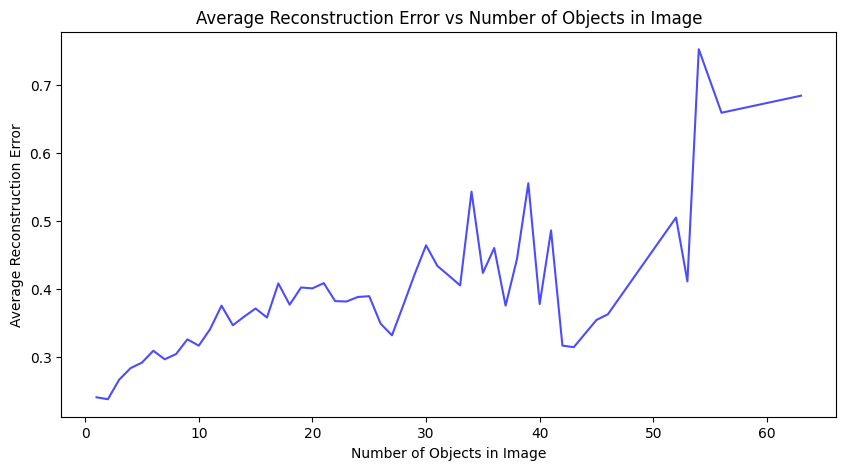

In [27]:
# A line graph that shows the average reconstruction error for each image count
plt.rcParams['figure.figsize'] = [10, 5]
plt.title("Average Reconstruction Error vs Number of Objects in Image")
plt.xlabel("Number of Objects in Image")
plt.ylabel("Average Reconstruction Error")
count_to_average_reconstuction_error_list = (sorted(count_to_average_reconstuction_error.items()))
x = [k for k, v in count_to_average_reconstuction_error_list]
y = [v for k, v in count_to_average_reconstuction_error_list]
plt.plot(x, y, color='blue', alpha=0.7, label='Average Reconstruction Error')

In [28]:
# Average Reconstruction Error in bins of 10
count_to_average_reconstuction_error_bins = {}
for count, average_reconstruction_error in count_to_average_reconstuction_error.items():
    bin_number = count // 10
    if bin_number in count_to_average_reconstuction_error_bins:
        count_to_average_reconstuction_error_bins[bin_number].append(average_reconstruction_error)
    else:
        count_to_average_reconstuction_error_bins[bin_number] = [average_reconstruction_error]
count_to_average_reconstuction_error_bins = {f"{k*10} - {(k+1)*10 - 1}": f"{(sum(v) / len(v)):.3f}" for k, v in count_to_average_reconstuction_error_bins.items()}
count_to_average_reconstuction_error_bins_list = sorted(count_to_average_reconstuction_error_bins.items())

In [29]:
count_to_average_reconstuction_error_bins_list

[('0 - 9', '0.284'),
 ('10 - 19', '0.366'),
 ('20 - 29', '0.383'),
 ('30 - 39', '0.452'),
 ('40 - 49', '0.369'),
 ('50 - 59', '0.582'),
 ('60 - 69', '0.684')]

# ITM Accuracy with mask ratio

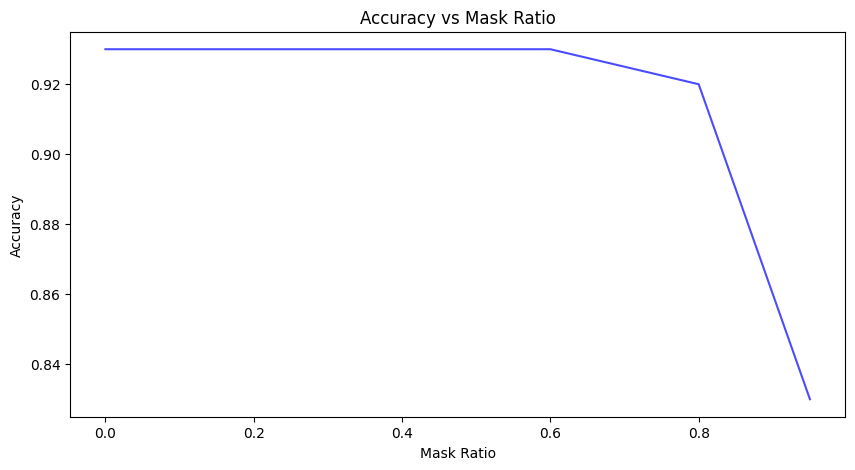

In [47]:
mask_ratio_to_accuracy = {
    0.0: 0.93,
    0.2: 0.93,
    0.4: 0.93,
    0.6: 0.93,
    0.8: 0.92,
    0.95: 0.83,
}
# Line graph that shows the accuracy of the model for different mask ratios
plt.rcParams['figure.figsize'] = [10, 5]
plt.title("Accuracy vs Mask Ratio")
plt.xlabel("Mask Ratio")
plt.ylabel("Accuracy")
x = [k for k, v in mask_ratio_to_accuracy.items()]
x.sort()
y = [mask_ratio_to_accuracy[k] for k in x]
plt.plot(x, y, color='blue', alpha=0.7, label='Accuracy')

# Effective Rank

In [48]:
def compute_effective_rank(embeddings):
    # Normalize embeddings
    embeddings = torch.nn.functional.normalize(embeddings, dim=1)
    
    # Compute covariance matrix
    cov_matrix = torch.matmul(embeddings.T, embeddings) / embeddings.size(0)
    
    # Perform SVD
    U, S, V = torch.svd(cov_matrix)
    
    # Normalize singular values
    singular_values = S / S.sum()

    # Compute entropy
    entropy = -torch.sum(singular_values * torch.log(singular_values + 1e-8))
    
    # Compute effective rank
    effective_rank = torch.exp(entropy)
    
    return effective_rank.item()

In [60]:
hidden_embeddings_cache_path = "cache_hidden_embeddings.pkl"
if os.path.exists(hidden_embeddings_cache_path):
    hidden_embeddings_cache = load_python_obj(hidden_embeddings_cache_path)
    print(f"Loaded hidden embeddings cache from {hidden_embeddings_cache_path}")
else:
    hidden_embeddings_cache = {}
    print("Initialized new hidden embeddings cache")
mask_ratio = 0.75
bs = 64
results = []
num_correct = 0
num_total = 0
from tqdm import tqdm
import torch
import random
with torch.no_grad():
    pbar = tqdm(total=len(list_for_vlc), position=0, leave=True)
    pbar.set_description(f'Val Acc: {num_correct/num_total if num_total > 0 else 0:.2f}')
    for i in range(0, len(list_for_vlc), bs):
        batch = []
        batch_image_paths = []
        for k in range(i, min(i+bs, len(list_for_vlc))):
            random.seed(k)
            curr_item = list_for_vlc[k]
            image_full_path = os.path.join(val_image_folder, curr_item[0])
            new_curr_item = (load_image(image_full_path), curr_item[1], torch.tensor(curr_item[2]))
            batch.append(new_curr_item)
            batch_image_paths.append(curr_item[0])
        images_tensor, embeddings, text_attention_mask, labels_tensor = collate_fn(batch)
        # loss, y, mask, itm_probs = text_conditioned_vitL_P16(images_tensor, embeddings, text_attention_mask, mask_ratio=0, skip_cross_attn=False)
        # def forward(self, imgs, text_embeddings, text_attention_mask, mask_ratio=0.75, skip_cross_attn=False):
        latent, mask, ids_restore = text_conditioned_vitL_P16.forward_encoder(images_tensor, embeddings, text_attention_mask, mask_ratio, skip_cross_attn=False)

        for j in range(images_tensor.shape[0]):
            hidden_embeddings_cache[batch_image_paths[j]] = latent[j].detach().cpu().numpy()
        # Update progress bar with new accuracy
        # accuracy = num_correct / num_total if num_total > 0 else 0
        # pbar.set_description(f'Val Acc: {accuracy:.2f}')
        pbar.update(bs)
save_python_obj(hidden_embeddings_cache, hidden_embeddings_cache_path)

Loaded hidden embeddings cache from cache_hidden_embeddings.pkl


Val Acc: 0.00: : 5056it [01:49, 46.14it/s] 
Val Acc: 0.00: 100%|█████████▉| 4992/5000 [00:57<00:00, 89.08it/s]

In [63]:
hidden_embeddings_cache_path = "cache_hidden_embeddings.pkl"
if os.path.exists(hidden_embeddings_cache_path):
    hidden_embeddings_cache = load_python_obj(hidden_embeddings_cache_path)
    print(f"Loaded hidden embeddings cache from {hidden_embeddings_cache_path}")
else:
    hidden_embeddings_cache = {}
    print("Initialized new hidden embeddings cache")

def get_effective_rank_val_dataset(val_dir):
    num_images = len(os.listdir(val_dir))
    final_np_array = np.zeros((num_images, 50, 1024))
    with tqdm(total=num_images, desc="Processing images") as pbar:
        for ind, image_name in enumerate(tqdm(sorted(os.listdir(val_dir)))):
            if image_name in hidden_embeddings_cache:
                hidden_embed_image = hidden_embeddings_cache[image_name]
            else:
                print("ERROR: run the previous cell", image_name)
                break
            final_np_array[ind] = hidden_embed_image
            # print(f"Hidden Embeddings Shape: {hidden_embed_image.shape}")
            pbar.update(1)
            # pbar.set_postfix(effective_rank="Speed Mode!")
    final_np_array = final_np_array.reshape(num_images*50, 1024)
    with torch.no_grad():
        effective_rank = compute_effective_rank(torch.tensor(final_np_array))
    return effective_rank, final_np_array

effective_rank, final_np_array = get_effective_rank_val_dataset(val_dir)
save_python_obj(hidden_embeddings_cache, hidden_embeddings_cache_path)
print(f"Effective Rank on Val Dataset: {effective_rank}")

Loaded hidden embeddings cache from cache_hidden_embeddings.pkl






Processing images: 100%|██████████| 5000/5000 [00:00<00:00, 12935.03it/s]


Effective Rank on Val Dataset: 12.028226568571375
